# Semantic Caching using Bedrock & REC

## 1. Install the required libraries

In [3]:
!pwd
!pip install --upgrade pip

# Install required redis libraries
!python3 -m pip install boto3

%pip install -q redis
%pip -q install pandas
%pip install matplotlib


/root/redis-bedrock-gen-ai-app
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Initialise bedrock client.

In [18]:
import boto3
import json
# List different FMs
bedrock2 = boto3.client('bedrock')
#bedrock2.list_foundation_models()


## 3. Construct Prompt

In [ ]:
prompt_data="""Compose a radiology report for a 60-year-old male patient with persistent cough and shortness of breath."""

## 4. Use Amazon Titan LLM to answer the question

In [9]:
# Use Amazon Titan LLM to answer the question
import time

body = json.dumps({"inputText": prompt_data})
modelId = 'amazon.titan-tg1-large' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

bedrock = boto3.client('bedrock-runtime')

time1 = time.time()
response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
time2 = time.time()
elapsedTime = f"{(time2-time1):.3f} seconds"
response_body_titan = json.loads(response.get('body').read())

print("Model took "+elapsedTime)
print("Model Response::")
print(response_body_titan.get('results')[0].get('outputText'))

Model took 3.395 seconds
Model Response::

Here is a radiology report for a 60-year-old male patient with persistent cough and shortness of breath:

Subject: 60-year-old male patient with persistent cough and shortness of breath

Medical History: The patient has a history of chronic obstructive pulmonary disease (COPD) and is currently on medication to manage his symptoms. He has been experiencing a persistent cough and shortness of breath for the past few weeks.

Physical Examination: On physical examination, the patient was noted to have a respiratory rate of 20 breaths per minute, with oxygen saturation of 9


## 5.  Use Titan Embeddings Model to generate our Embeddings

In [10]:
# We will be using the Titan Embeddings Model to generate our Embeddings.

def get_embedding(body):
    modelId = 'amazon.titan-e1t-medium'
    accept = 'application/json'
    contentType = 'application/json'

    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

body = json.dumps({"inputText": prompt_data})

query_embedding = get_embedding(body)

## 6. Configure Redis

In [11]:
# Ensure connectivity to Redis Endpoints. Replace the host, port and password from the actual Redis Database endpoint details.
import redis
client = redis.Redis(host = 'redis-10489.c285.us-west-2-2.ec2.cloud.redislabs.com', port=10489, password='admin', decode_responses=True)
client.ping()

# prepare a JSON object and persist it into Redis Enterprise Cloud.

persist_query_object = {
    'query': prompt_data,
    'query_embedding': query_embedding, 
    'response': response_body_titan.get('results')[0].get('outputText')
}
client.json().set('query_responses:001', '$', persist_query_object)

True

## 7. Prepare list of search queries that are similar to the original prompt

In [12]:
# Prepare a list of search queries that are somewhat similar to the original prompt entered above and some that are entirely different

similarity_search_queries = [
    #Similar to original prompt
    "Prepare a radiology report for a 60-year-old man with chronic cough and breathlessness.",
    "Craft a report: 60-year-old male patient, chronic cough, breathlessness.",
    "Generate a report on a 60-year-old male with persistent cough.",
    "Create a medical report: male patient, 60, chronic cough, breathlessness.",
    #That are totally different and not similar to original prompt
    "Design an interactive website for an online art gallery exhibition.",
    "Calculate monthly expenses and analyze financial trends for a small business.",
    "Develop a vegan recipe for a delicious gluten-free dessert option.",
    "Construct a strategic plan for expanding a nonprofit organization's outreach."
]

# Lets vectorize these search query embeddings using Bedrock Tital LLM.
similarity_search_queries_embeddings = []

for input_query in similarity_search_queries:
    input_query = json.dumps({"inputText": input_query})
    query_response = get_embedding(body=input_query)
    similarity_search_queries_embeddings.append(query_response)

## 8. Create index in Redis

In [13]:
# Lets start with creating an index for the query collection in Redis.

# Create these query collection searchable.
# FT.CREATE idx:query_responses_vss ON JSON
#   PREFIX 1 query_responses: SCORE 1.0
#   SCHEMA 
#      $.query TEXT WEIGHT 1.0 NOSTEM
#      $.query_embedding AS vector VECTOR FLAT 6 TYPE FLOAT32 DIM 4096 DISTANCE_METRIC COSINE
#


from redis.commands.search.field import TagField, TextField, NumericField, VectorField
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import Query

INDEX_NAME = 'idx:query_responses_vss'
DOC_PREFIX = 'query_responses:'
VECTOR_DIMENSION = 4096

try:
    # check to see if index exists
    client.ft(INDEX_NAME).info()
    print('Index already exists!')
except:
    # schema
    schema = (
        TextField('$.query', no_stem=True, as_name='query'),
        VectorField('$.query_embedding',
            'FLAT', {
                'TYPE': 'FLOAT32',
                'DIM': VECTOR_DIMENSION,
                'DISTANCE_METRIC': 'COSINE',
            },  as_name='vector'
        ),
        TextField('$.response', no_stem=True, as_name='response'),
    )

    # index Definition
    definition = IndexDefinition(prefix=[DOC_PREFIX], index_type=IndexType.JSON)

    # create Index
    client.ft(INDEX_NAME).create_index(fields=schema, definition=definition)


## 9. Construct vector search query 

In [14]:
# Create a KNN query. KNN is a foundational algorithm used in vector similarity search, where the goal is 
# to find the most similar items to a given query item. Using the chosen distance metric, the KNN algorithm 
# calculates the distance between the query vector and each vector in the database. 
# It then returns the 'K' items with the smallest distances to the query vector. 
# These are considered to be the most similar items.
query = (
    Query('(*)=>[KNN 3 @vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'query', 'response')
     .dialect(2)
)

## 10. Construct result using Redis for semantic caching  

In [15]:
### If they are similar, get the response from Redis Database cache instead of asking the Amazon Titan LLM thus saving compute power. If they are not similar, get the response from LLM.
import pandas as pd
import time
import numpy as np

from IPython.display import display, HTML

INDEX_NAME = 'idx:query_responses_vss'

results_list = []

def create_query_table(query, queries, encoded_queries, extra_params = {}):
    
    
    VSS_SCORE_THRESHOLD = 0.75
    for i, encoded_query in enumerate(encoded_queries):
        start_time = time.time()
        result_docs = client.ft(INDEX_NAME).search(query, { 'query_vector' : np.array(encoded_query, dtype=np.float32).tobytes() } ).docs
        end_time = time.time()
        elapsed_time = end_time - start_time
        elapsed_time_in_sec = f"{elapsed_time:.3f}"
        
        fetch_from = ""
        response = ""
        persisted_query = ""
        
        for doc in result_docs:
            vector_score = round(1 - float(doc.vector_score), 2)           
            
            # Check if the vector_score value is above or equal to VSS_SCORE_THRESHOLD ( default = 0.75, set above)
            # If above 0.75, it is almost 75% or more similar to the original prompt. 
            # In that case, fetch the record from REDIS.
            # Otherwise, invoke Amazon Titan LLM and get a newer response. 
            if vector_score >= VSS_SCORE_THRESHOLD:
                fetch_from = "Semantic Caching"
                response = doc.response
                persisted_query = doc.query
            else:
                fetch_from = "Without Semantic Caching"
                response = "This will be a new call to Bedrock LLM"
                body = json.dumps({"inputText": queries[i]})
                modelId = 'amazon.titan-tg1-large' # change this to use a different version from the model provider
                accept = 'application/json'
                contentType = 'application/json'
                persisted_query = 'N/A'
                
                start_time = time.time()
                response_llm = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
                end_time = time.time()
                elapsed_time = end_time - start_time
                elapsed_time_in_sec = f"{elapsed_time:.3f}"
                
                response_body_titan = json.loads(response_llm.get('body').read())
                response = response_body_titan.get('results')[0].get('outputText')
            
            results_list.append({
                'query': queries[i], 
                'score': vector_score,
                'latency': elapsed_time_in_sec,
                'fetched from': fetch_from,
                'persisted_query': persisted_query,
                'response': response
            })

    # Pretty-print the table
    queries_table = pd.DataFrame(results_list)
    queries_table.sort_values(by=['score', 'query'], ascending=[False, True], inplace=True)
    queries_table['query'] = queries_table.groupby('query')['query'].transform(lambda x: [x.iloc[0]] + ['']*(len(x)-1))
    queries_table['response'] = queries_table['response'].apply(lambda x: (x[:497] + '...') if len(x) > 500 else x)
    html = queries_table.to_html(index=False)
    display(HTML(html))

## 11. Go ahead and display the results

In [16]:
# Now goahead and display the results:

create_query_table(query, similarity_search_queries, similarity_search_queries_embeddings)

query,score,latency,fetched from,persisted_query,response
Prepare a radiology report for a 60-year-old man with chronic cough and breathlessness.,0.96,0.002,Semantic Caching,Compose a radiology report for a 60-year-old male patient with persistent cough and shortness of breath.,"\nHere is a radiology report for a 60-year-old male patient with persistent cough and shortness of breath:\n\nSubject: 60-year-old male patient with persistent cough and shortness of breath\n\nMedical History: The patient has a history of chronic obstructive pulmonary disease (COPD) and is currently on medication to manage his symptoms. He has been experiencing a persistent cough and shortness of breath for the past few weeks.\n\nPhysical Examination: On physical examination, the patient was noted t..."
Generate a report on a 60-year-old male with persistent cough.,0.79,0.001,Semantic Caching,Compose a radiology report for a 60-year-old male patient with persistent cough and shortness of breath.,"\nHere is a radiology report for a 60-year-old male patient with persistent cough and shortness of breath:\n\nSubject: 60-year-old male patient with persistent cough and shortness of breath\n\nMedical History: The patient has a history of chronic obstructive pulmonary disease (COPD) and is currently on medication to manage his symptoms. He has been experiencing a persistent cough and shortness of breath for the past few weeks.\n\nPhysical Examination: On physical examination, the patient was noted t..."
"Craft a report: 60-year-old male patient, chronic cough, breathlessness.",0.78,0.001,Semantic Caching,Compose a radiology report for a 60-year-old male patient with persistent cough and shortness of breath.,"\nHere is a radiology report for a 60-year-old male patient with persistent cough and shortness of breath:\n\nSubject: 60-year-old male patient with persistent cough and shortness of breath\n\nMedical History: The patient has a history of chronic obstructive pulmonary disease (COPD) and is currently on medication to manage his symptoms. He has been experiencing a persistent cough and shortness of breath for the past few weeks.\n\nPhysical Examination: On physical examination, the patient was noted t..."
"Create a medical report: male patient, 60, chronic cough, breathlessness.",0.75,0.001,Semantic Caching,Compose a radiology report for a 60-year-old male patient with persistent cough and shortness of breath.,"\nHere is a radiology report for a 60-year-old male patient with persistent cough and shortness of breath:\n\nSubject: 60-year-old male patient with persistent cough and shortness of breath\n\nMedical History: The patient has a history of chronic obstructive pulmonary disease (COPD) and is currently on medication to manage his symptoms. He has been experiencing a persistent cough and shortness of breath for the past few weeks.\n\nPhysical Examination: On physical examination, the patient was noted t..."
Construct a strategic plan for expanding a nonprofit organization's outreach.,0.06,3.269,Without Semantic Caching,N/A,"\nHere is a strategic plan for expanding a nonprofit organization's outreach:\n1. Define the target audience: Identify the specific demographic, geographic, and psychographic characteristics of the people the nonprofit organization wants to reach. This will help the organization develop targeted outreach strategies.\n2. Develop a marketing plan: Create a marketing plan that outlines the strategies the organization will use to reach its target audience. This may include social media campaigns, pu..."
Calculate monthly expenses and analyze financial trends for a small business.,0.04,3.238,Without Semantic Caching,N/A,"\nCertainly! Here's a step-by-step guide to monthly expenses and financial trend analysis for a small business:\n1. Gather all financial statements, including income statements, balance sheets, and cash flow statements, for the current and previous months.\n2. Classify expenses into fixed (e.g., rent, utilities) and variabl

## 12. Check the LLM latency Vs Sematic caching 

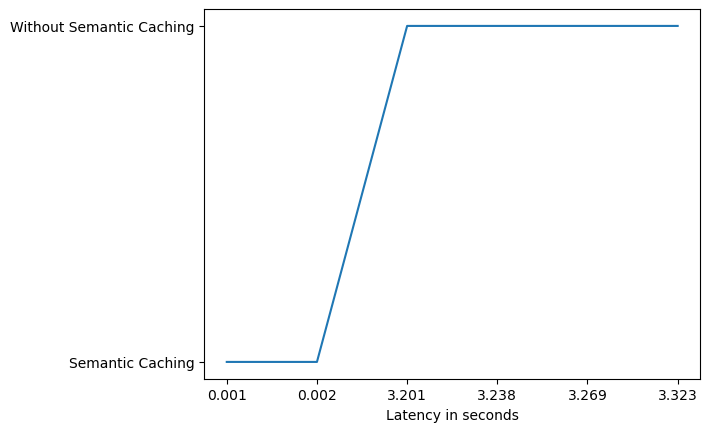

In [17]:
# Visually check the performance: with and without semantic caching
import matplotlib.pyplot as plt 

qry_table = pd.DataFrame(results_list)
plt.xlabel('Latency in seconds') 
qry_table.sort_values(by=['latency'], ascending=[True], inplace=True)
plt.plot(qry_table['latency'], qry_table['fetched from']) 
plt.show()
